<a href="https://colab.research.google.com/github/jafetimbre/verbose-projects/blob/master/artificial-intelligence/rbf-stock-prec/rbf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools

In [2]:
cols = [ "Date", "Close" ]
tsla_data = pd.read_csv("https://raw.githubusercontent.com/jafetimbre/verbose-projects/master/statistics/stock-price-pred/res/tsla_2yr_data.csv", usecols=cols)
tsla_data = tsla_data[:450]
tsla_data.head()

,Date,Close
0,2019-11-25,67.267998
1,2019-11-26,65.783997
2,2019-11-27,66.258003
3,2019-11-29,65.987999
4,2019-12-02,66.973999


In [3]:
tsla_data.describe()

,Close
count,450.000000
mean,433.907786
std,252.867234
min,65.783997
25%,161.976002
50%,425.855011
75%,667.444992
max,883.090027


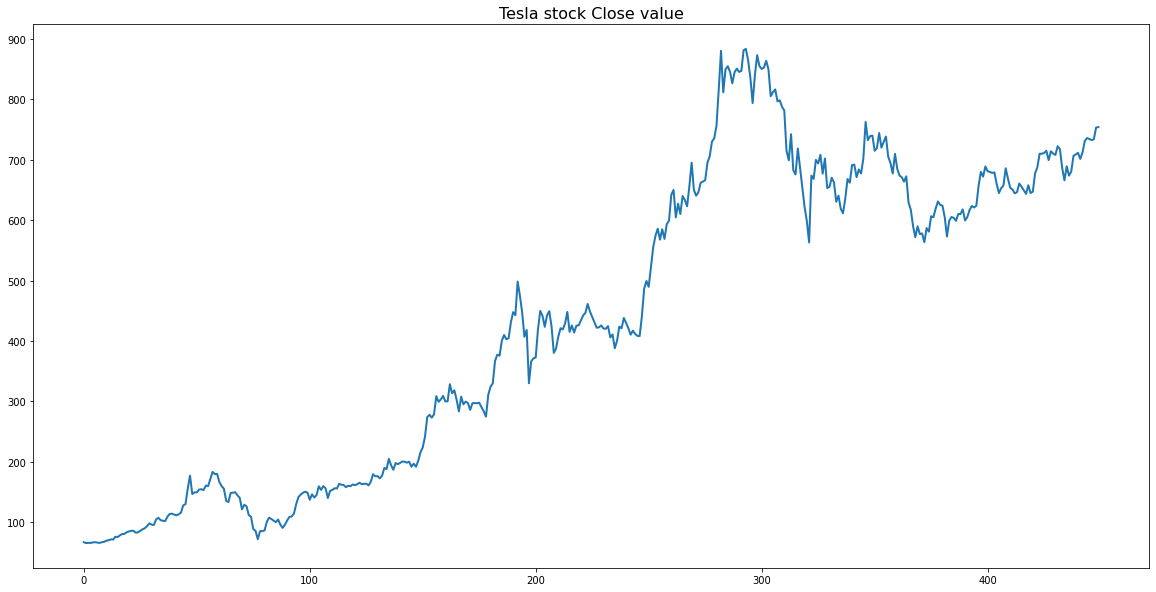

In [4]:
plt.figure(figsize=(20,10))
plt.title('Tesla stock Close value', size=16)
plt.plot(tsla_data.Close, linewidth=2)
plt.show()

In [5]:
max = tsla_data.Close.max()
data = pd.DataFrame({'val': tsla_data.Close / max})
data.describe()

,val
count,450.000000
mean,0.491352
std,0.286344
min,0.074493
25%,0.183420
50%,0.482233
75%,0.755806
max,1.000000


In [6]:
def segment_data(data, train_ratio):
    separation_point = int(np.floor(len(data) * train_ratio))
    return (data[:separation_point], data[separation_point:], separation_point)

(train_data, test_data, seg) = segment_data(list(data.val), .8)

len(train_data)

360

In [7]:
class RBF():
    def __init__(self, train_data, pred_win=1, learn_rate=.02):
        self.train_data = train_data
        self.pred_win = pred_win
        self.hidden_dim = len(train_data)-pred_win

        self.learning_rate = learn_rate

        self.G = np.zeros(self.hidden_dim)
        self.W = 2 * np.random.random(self.hidden_dim) - 1
        self.Xi = [ train_data[i:i+self.pred_win] for i in range(0, self.hidden_dim) ]


    # def g(self, x, xi):
    #     return np.exp(-np.power(np.linalg.norm(x-xi), 2))

    def g(self, x, xi):
        return np.exp(-1 / (2 * (np.std(xi) if np.std(xi) != 0 else .00002) **2) * np.linalg.norm(x-xi)**2)


    def compute(self, x):
        if len(x) != self.pred_win:
            raise Exception("Input vector dim invalid")
        self.G = np.array([ self.g(x, np.array(self.Xi[i])) for i in range(self.hidden_dim) ])
        return np.sum(np.multiply(self.G, self.W))


    def update(self, error):
        for i in range(self.hidden_dim):
            deltaW = self.learning_rate * self.G[i] * error
            self.W[i] += deltaW


    def fit(self, iters=100):
        for i in range(iters):
            for j in range(len(self.Xi)):  

                x = self.Xi[j]
                z = self.train_data[len(x)+j]
                # print(self.W)

                Y = self.compute(np.array(x))
                err = (Y-z) ** 2
                self.update(err)

In [8]:
rbf = RBF(train_data, pred_win=10)

rbf.fit(1)

In [9]:
from keras.layers import Layer
from keras import backend as K

class RBFLayer(Layer):
    def __init__(self, units, gamma, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units
        self.gamma = K.cast_to_floatx(gamma)

    def build(self, input_shape):
        self.mu = self.add_weight(name='mu',
                                  shape=(int(input_shape[1]), self.units),
                                  initializer='uniform',
                                  trainable=True)
        super(RBFLayer, self).build(input_shape)

    def call(self, inputs):
        diff = K.expand_dims(inputs) - self.mu
        l2 = K.sum(K.pow(diff, 2), axis=1)
        res = K.exp(-1 * self.gamma * l2)
        return res

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.units)

In [10]:
import pandas as pd
import numpy as np
from keras.layers import Dense, Flatten
from keras.models import Sequential
from keras.losses import binary_crossentropy

model = Sequential()
model.add(Flatten(input_shape=(10,10)))
model.add(RBFLayer(10, 0.5))
model.add(Dense(1))

model.compile(optimizer='rmsprop', loss='binary_crossentropy')

In [11]:
model.compile(loss='mse', optimizer='rmsprop')

In [12]:
history = model.fit(train_data[:-10], train_data[10:], epochs=150, batch_size=10)

Epoch 1/150
35/35 [==============================] - 1s 2ms/step - loss: 0.2572
Epoch 2/150
35/35 [==============================] - 0s 1ms/step - loss: 0.2260
Epoch 3/150
35/35 [==============================] - 0s 2ms/step - loss: 0.2013
Epoch 4/150
35/35 [==============================] - 0s 1ms/step - loss: 0.1788
Epoch 5/150
35/35 [==============================] - 0s 2ms/step - loss: 0.1591
Epoch 6/150
35/35 [==============================] - 0s 2ms/step - loss: 0.1407
Epoch 7/150
35/35 [==============================] - 0s 1ms/step - loss: 0.1238
Epoch 8/150
35/35 [==============================] - 0s 1ms/step - loss: 0.1093
Epoch 9/150
35/35 [==============================] - 0s 1ms/step - loss: 0.0957
Epoch 10/150
35/35 [==============================] - 0s 1ms/step - loss: 0.0834
Epoch 11/150
35/35 [==============================] - 0s 2ms/step - loss: 0.0726
Epoch 12/150
35/35 [==============================] - 0s 2ms/step - loss: 0.0629
Epoch 13/150
35/35 [=================

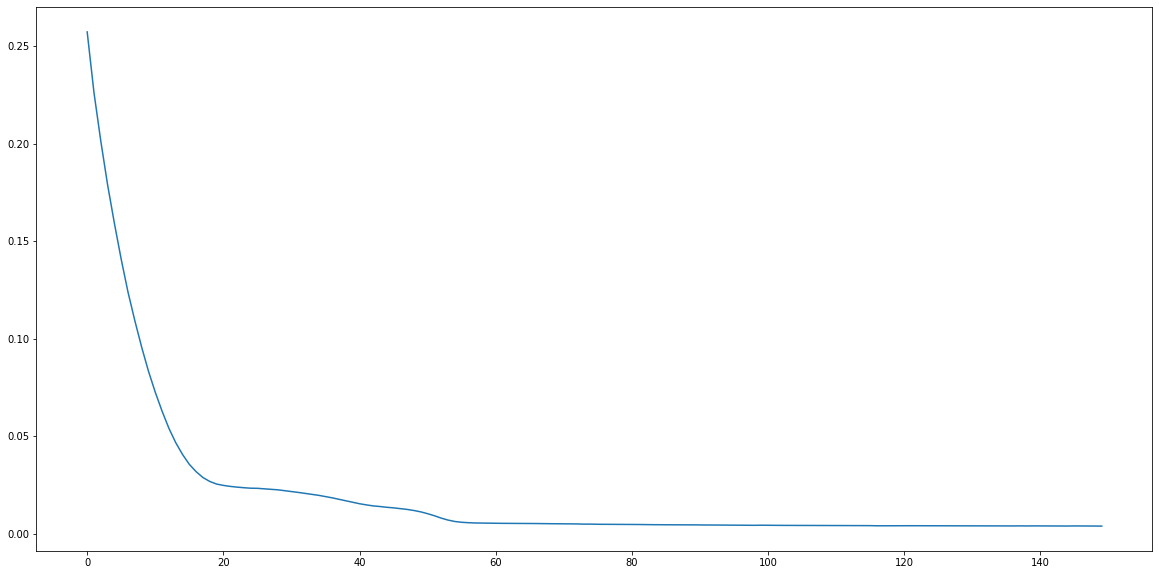

In [13]:
plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])

In [14]:
te = model.predict(train_data)

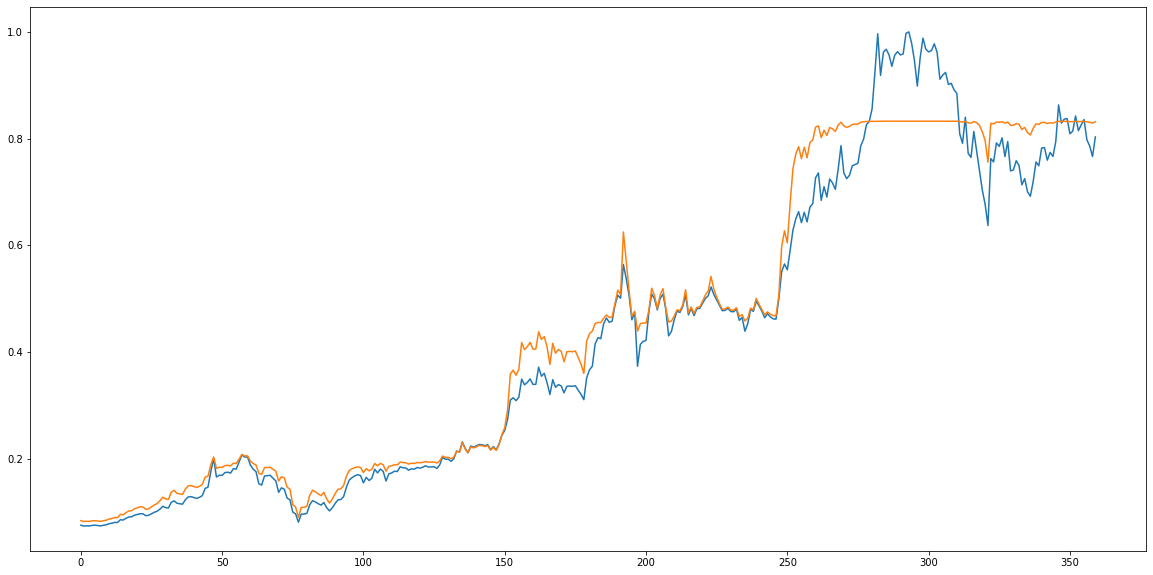

In [15]:
plt.figure(figsize=(20,10))
plt.plot(train_data)
plt.plot(te)

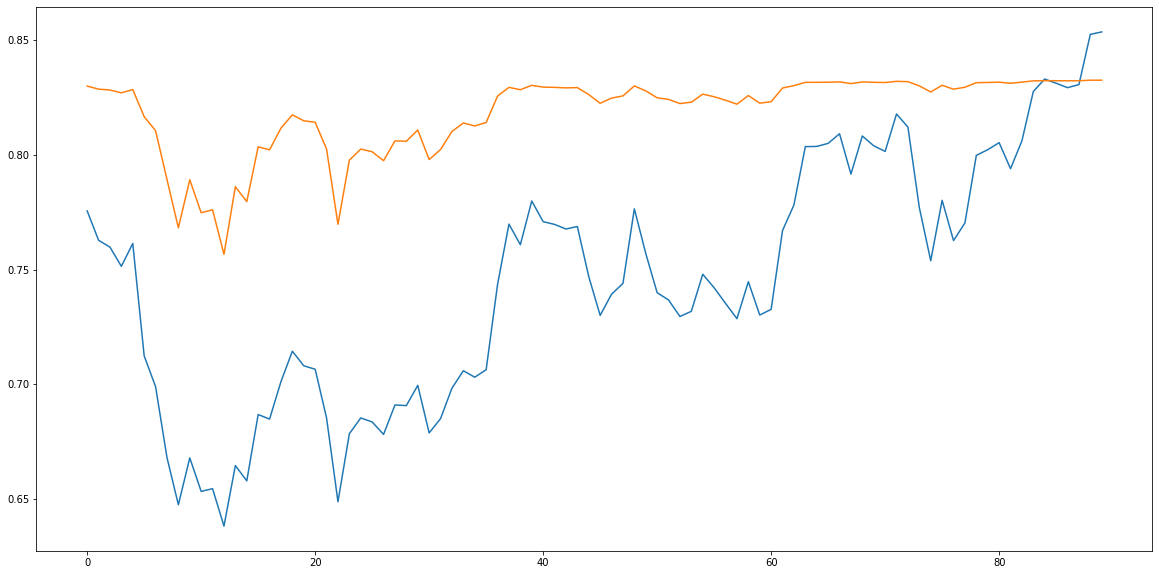

In [16]:
tst = model.predict(test_data)
plt.figure(figsize=(20,10))
plt.plot(test_data)
plt.plot(tst)

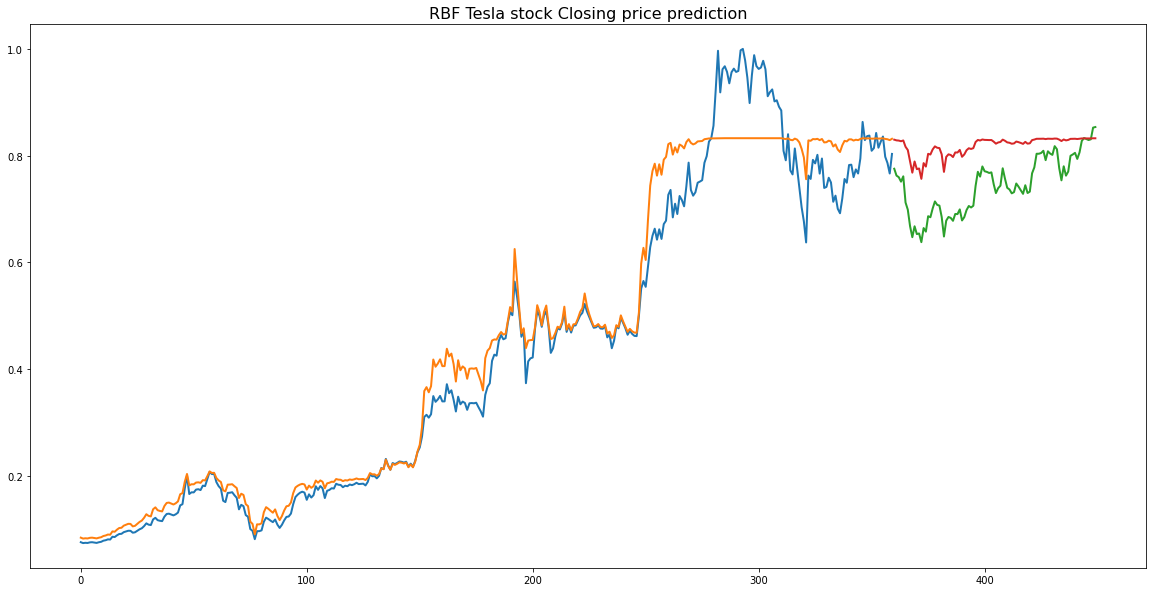

In [17]:
plt.figure(figsize=(20,10))
plt.title('RBF Tesla stock Closing price prediction', size=16)

y_train = list(range(seg))
y_test = list(range(seg,seg+len(test_data)))

plt.plot(y_train, train_data, linewidth=2)
plt.plot(y_train, te, linewidth=2)

plt.plot(y_test, test_data, linewidth=2)
plt.plot(y_test, tst, linewidth=2)

plt.show()